In [12]:
import json
import collections
import re
import nltk
from nltk.corpus import stopwords
import ipywidgets as widgets
from datetime import date, timedelta, datetime
import pandas as pd
import matplotlib.pyplot as plt


nltk.download('stopwords')

count = collections.Counter()
cachedStopWords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
f = open('dataset.json')
dataset = json.load(f)

In [14]:
series = []
for i in dataset:
  series.append(i["series"])
print("Series are:", series)

Series are: ['ADM 50', 'ADM 51', 'ADM 52', 'ADM 53', 'ADM 54', 'ADM 55', 'ADM 101', 'MT 32', 'OS 1', 'OS 2', 'OS 3', 'OS 4', 'OS 5']


In [15]:
checkboxes = [widgets.Checkbox(value=False, description=label) for label in series]
output = widgets.VBox(children=checkboxes)
display(output)

In [19]:
selected_data = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_data = selected_data + [checkboxes[i].description]
print(selected_data)

['OS 5']


In [20]:
for j in dataset:
  if j["series"] in selected_data:
    print("Series: " + j["series"])

    description = ""
    for i in j["results"]:
      description_sentence = i["record"]["description"].lower()
      description_sentence = ' '.join([word for word in description_sentence.split() if word not in stopwords.words("english")])
      words = re.findall(r'\w+', description_sentence)
      print("Five most frequent words in the description of the record titled '" + i["record"]["title"] + "' are:")
      for i in collections.Counter(words).most_common(5):
        print(i[0] + " which appeared " + str(i[1]) + " times.")
      description = description + description_sentence
    print("Five most frequent words in the description of", j["series"], "series are:")
    for i in collections.Counter(re.findall(r'\w+', description)).most_common(5):
      print(i[0] + " which appeared " + str(i[1]) + " times.")

Series: OS 5
Five most frequent words in the description of the record titled 'Areas of outstanding natural beauty: South Devon' are:
areas which appeared 1 times.
outstanding which appeared 1 times.
natural which appeared 1 times.
beauty which appeared 1 times.
south which appeared 1 times.
Five most frequent words in the description of the record titled 'Ordnance Survey: Maps and Plans' are:
series which appeared 4 times.
maps which appeared 4 times.
includes which appeared 2 times.
transport which appeared 2 times.
accumulation which appeared 1 times.
Five most frequent words in the description of the record titled 'Sheffield, and the surrounding parishes and townships (included in the Upper Division of the Wapentake...' are:
1 which appeared 2 times.
mile which appeared 2 times.
sheffield which appeared 1 times.
surrounding which appeared 1 times.
parishes which appeared 1 times.
Five most frequent words in the description of the record titled 'Physical map: Scotland' are:
physical

In [22]:
global_max = ("", 0)
for i in dataset:
  print(i["series"])
  local_max = 0
  for j in i["results"]:
    length = collections.Counter(re.findall(r'\w+', j["record"]["description"].lower())).total()
    if length > local_max:
      local_max = length
    print("Length of the description for the record titled '" + j["record"]["title"] + "':", length)
  print("Max length of the description for this series:", local_max)
  if global_max[1] < local_max:
    global_max = (i["series"], local_max)
print("Lengthiest description is for the series:", global_max[0], "with length", global_max[1])

ADM 50
Length of the description for the record titled 'Sir T. Williams': 3
Length of the description for the record titled 'T. Brodrick': 2
Length of the description for the record titled 'Sir J. Wallace': 3
Length of the description for the record titled 'J. Colpoys': 2
Length of the description for the record titled 'Sir H. Harvey': 3
Length of the description for the record titled 'Sir J. B. Warren': 4
Length of the description for the record titled 'W. Waldegrave': 2
Length of the description for the record titled 'Captain C. F. Hotham, S.N.O. (July-Dec.)': 9
Length of the description for the record titled 'G. Murray': 2
Length of the description for the record titled 'Rear Admiral George L. Atkinson Willes': 6
Length of the description for the record titled 'Vice Admiral Sir Wm. N. W. Hewett, V.C., K.C.B., K.C.S.I., (VAC)': 17
Length of the description for the record titled 'Sir G. Walton': 3
Length of the description for the record titled 'Commodore J. E. C. Goodrich, M.V.O. Com

In [27]:
covering_dates = []
for i in dataset:
  print(i["series"])
  if i["series"] != "OS 2":
    series_start_date = datetime.strptime("31/12/9999", "%d/%m/%Y")
    series_end_date = datetime.strptime("01/01/0001", "%d/%m/%Y")
    records = []
    for k, j in enumerate(i["results"]):
      if series_start_date > datetime.strptime(j["record"]["startDate"], "%d/%m/%Y"):
        series_start_date = datetime.strptime(j["record"]["startDate"], "%d/%m/%Y")
      if series_end_date < datetime.strptime(j["record"]["endDate"], "%d/%m/%Y"):
        series_end_date = datetime.strptime(j["record"]["endDate"], "%d/%m/%Y")
      records.append([k, datetime.strptime(j["record"]["startDate"], "%d/%m/%Y"), datetime.strptime(j["record"]["endDate"], "%d/%m/%Y")])
    print("Covering dates for this series:", records)
    covering_dates.append({
                "series_name": i["series"],
                "id": [i["series"]+"_"+str(k[0]) for k in records],
                "startDate": [k[1] for k in records],
                "endDate": [k[2] for k in records]
            })
    # covering_dates[i["series"]] = [series_start_date, series_end_date, records]
print("Covering dates:", covering_dates)

ADM 50
Covering dates for this series: [[0, datetime.datetime(1811, 4, 9, 0, 0), datetime.datetime(1811, 8, 30, 0, 0)], [1, datetime.datetime(1758, 4, 1, 0, 0), datetime.datetime(1760, 3, 22, 0, 0)], [2, datetime.datetime(1796, 9, 1, 0, 0), datetime.datetime(1796, 9, 29, 0, 0)], [3, datetime.datetime(1796, 10, 29, 0, 0), datetime.datetime(1796, 12, 31, 0, 0)], [4, datetime.datetime(1795, 8, 31, 0, 0), datetime.datetime(1796, 3, 30, 0, 0)], [5, datetime.datetime(1811, 1, 21, 0, 0), datetime.datetime(1811, 2, 22, 0, 0)], [6, datetime.datetime(1797, 4, 28, 0, 0), datetime.datetime(1797, 11, 23, 0, 0)], [7, datetime.datetime(1885, 1, 1, 0, 0), datetime.datetime(1885, 12, 31, 0, 0)], [8, datetime.datetime(1794, 4, 17, 0, 0), datetime.datetime(1796, 12, 30, 0, 0)], [9, datetime.datetime(1903, 1, 1, 0, 0), datetime.datetime(1903, 12, 31, 0, 0)], [10, datetime.datetime(1886, 1, 1, 0, 0), datetime.datetime(1887, 12, 31, 0, 0)], [11, datetime.datetime(1734, 3, 4, 0, 0), datetime.datetime(1735, 1

In [28]:
covering_dates_frame = pd.DataFrame(covering_dates)

print(covering_dates_frame)

   series_name                                                 id  \
0       ADM 50  [ADM 50_0, ADM 50_1, ADM 50_2, ADM 50_3, ADM 5...   
1       ADM 51  [ADM 51_0, ADM 51_1, ADM 51_2, ADM 51_3, ADM 5...   
2       ADM 52  [ADM 52_0, ADM 52_1, ADM 52_2, ADM 52_3, ADM 5...   
3       ADM 53  [ADM 53_0, ADM 53_1, ADM 53_2, ADM 53_3, ADM 5...   
4       ADM 54  [ADM 54_0, ADM 54_1, ADM 54_2, ADM 54_3, ADM 5...   
5       ADM 55  [ADM 55_0, ADM 55_1, ADM 55_2, ADM 55_3, ADM 5...   
6      ADM 101  [ADM 101_0, ADM 101_1, ADM 101_2, ADM 101_3, A...   
7        MT 32  [MT 32_0, MT 32_1, MT 32_2, MT 32_3, MT 32_4, ...   
8         OS 1  [OS 1_0, OS 1_1, OS 1_2, OS 1_3, OS 1_4, OS 1_...   
9         OS 3  [OS 3_0, OS 3_1, OS 3_2, OS 3_3, OS 3_4, OS 3_...   
10        OS 4  [OS 4_0, OS 4_1, OS 4_2, OS 4_3, OS 4_4, OS 4_...   
11        OS 5  [OS 5_0, OS 5_1, OS 5_2, OS 5_3, OS 5_4, OS 5_...   

                                            startDate  \
0   [1811-04-09 00:00:00, 1758-04-01 00:00:00

TypeError: unhashable type: 'list'

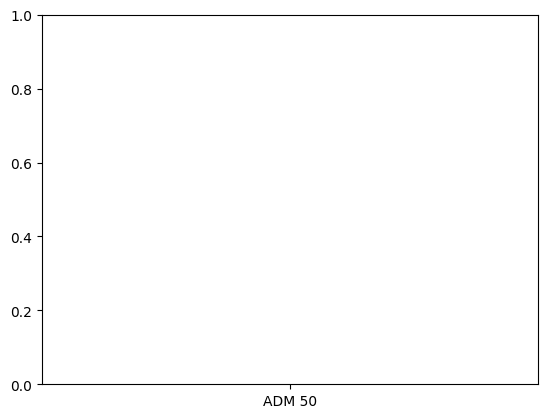

In [29]:
# covering_dates_frame["startDate"] = pd.to_datetime(covering_dates_frame["startDate"], dayfirst=True)
# covering_dates_frame["endDate"] = pd.to_datetime(covering_dates_frame["endDate"], dayfirst=True)

fig, ax = plt.subplots()

ax.barh(covering_dates_frame["id"], covering_dates_frame["series_name"])

ax.set_xlabel("ID")

ax.set_ylabel("Series Name")

plt.show()